In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader,random_split # önemli kütüphanelerin import edilmesi
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
from torchvision import models
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # GPU kontrolü

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]) # Resimin ImageNet Standartlarında normalize edilmesi

In [2]:
data = datasets.ImageFolder('./sar_data/', transform = transform) # dataset oluşturulması

np.random.seed(42)

train_size = int(0.70 * len(data)) # istenilen oranda datasetin train/test şeklinde bölünmesi
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])
print(f"Dataset has {len(data)} data points.")
print(f"Train Dataset has {len(train_dataset)} data points")
print(f"Test Dataset has {len(test_dataset)} data points.") 

Dataset has 1628 data points.
Train Dataset has 1139 data points
Test Dataset has 489 data points.


In [3]:
###HYPERPARAMETERS###
batch_size = 16
num_epochs = 20
learning_rate = 0.0003
###HYPERPARAMETERS###

In [4]:
test_dataset[325]
alongside_cout = building_cout = road_cout = vegetation_cout = water_cout = 0
train_alongside_cout = train_building_cout = train_road_cout = train_vegetation_cout = train_water_cout = 0
for x in range(len(test_dataset)):
    a, b = test_dataset[x]
    if b == 0:
        alongside_cout +=1
    if b == 1:
        building_cout+=1
    if b == 2:
        road_cout+=1
    if b == 3:
        vegetation_cout+=1
    if b == 4:
        water_cout+=1

for x in range(len(train_dataset)):
    a, b = train_dataset[x]
    if b == 0:
        train_alongside_cout +=1
    if b == 1:
        train_building_cout+=1
    if b == 2:
        train_road_cout+=1
    if b == 3:
        train_vegetation_cout+=1
    if b == 4:
        train_water_cout+=1

print(f"Alongside number of samples in train set : {train_alongside_cout}") # hangi kategoride kaç veri var
print(f"Alongside number of samples in test set : {alongside_cout}")
print(f"Building number of samples in train set : {train_building_cout}")
print(f"Building number of samples in test set : {building_cout}")
print(f"Road number of samples in train set : {train_road_cout}")
print(f"Road number of samples in test set : {road_cout}")
print(f"Vegetation number of samples in train set : {train_vegetation_cout}")
print(f"Vegetation number of samples in test set : {vegetation_cout}")
print(f"Water number of samples in train set : {train_water_cout}")
print(f"Water number of samples in test set : {water_cout}")

train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)

test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

Alongside number of samples in train set : 151
Alongside number of samples in test set : 65
Building number of samples in train set : 275
Building number of samples in test set : 117
Road number of samples in train set : 264
Road number of samples in test set : 128
Vegetation number of samples in train set : 232
Vegetation number of samples in test set : 80
Water number of samples in train set : 217
Water number of samples in test set : 99


In [5]:
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(
                         nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=1),
                         nn.BatchNorm2d(4),
                         nn.ReLU(inplace=True),
                         nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
                         nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1),
                         nn.BatchNorm2d(16),
                         nn.ReLU(inplace=True),
                         nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv3 = nn.Sequential(
                         nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1),
                         nn.BatchNorm2d(64),
                         nn.ReLU(inplace=True),
                         nn.MaxPool2d(kernel_size=3, stride=2))
        self.fc = nn.Sequential(
                         nn.Dropout(p=0.5),
                         nn.Linear(in_features=12*12*64, out_features=128),
                         nn.BatchNorm1d(128),
                         nn.ReLU(inplace=True),
                         nn.Dropout(p=0.5),
                         nn.Linear(in_features=128, out_features=32),
                         nn.BatchNorm1d(32),
                         nn.ReLU(inplace=True),
                         nn.Linear(in_features=32, out_features=10))
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view((x.shape[0],-1))
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

model = Model()
model.to(device)

#Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
import time
print_every = len(train_loader) - 1
loss_values = []
start_time = time.time()
total_step = len(train_loader)
epoch_times = []
total_step = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader): ###TRAİNİNG_LOOP
        epoch_start_time = time.time()
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i+1) % print_every == 0:
            epoch_times.append(time.time() - epoch_start_time)
            loss_values.append(running_loss / print_every)
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}: Batch Loss : {}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), running_loss / print_every))
            running_loss = 0
end_of_training = time.time() - start_time

arr_pred = np.empty((0,len(test_dataset)), int)

arr_label = np.empty((0,len(test_dataset)), int)

with torch.no_grad(): 
    correct = 0
    total = 0
    for images, labels in test_loader:  #PREDİCTİON LOOP
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred = predicted.cpu().numpy()
        lb = labels.cpu().numpy()
        arr_pred = np.append(arr_pred, pred)
        arr_label = np.append(arr_label, lb)
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/20], Step [71/72], Loss: 1.8318: Batch Loss : 2.0047405236203906
Epoch [2/20], Step [71/72], Loss: 1.5019: Batch Loss : 1.6468624212372471
Epoch [3/20], Step [71/72], Loss: 1.2990: Batch Loss : 1.3769289590943028
Epoch [4/20], Step [71/72], Loss: 1.1250: Batch Loss : 1.1483209133148193
Epoch [5/20], Step [71/72], Loss: 0.8446: Batch Loss : 0.951235724167085
Epoch [6/20], Step [71/72], Loss: 0.6228: Batch Loss : 0.7774302237470385
Epoch [7/20], Step [71/72], Loss: 0.4809: Batch Loss : 0.655296481830973
Epoch [8/20], Step [71/72], Loss: 0.4454: Batch Loss : 0.5425075955793891
Epoch [9/20], Step [71/72], Loss: 0.3909: Batch Loss : 0.4707426600892779
Epoch [10/20], Step [71/72], Loss: 0.3696: Batch Loss : 0.39257472606611926
Epoch [11/20], Step [71/72], Loss: 0.2860: Batch Loss : 0.3406959828776373
Epoch [12/20], Step [71/72], Loss: 0.2541: Batch Loss : 0.3216855595229377
Epoch [13/20], Step [71/72], Loss: 0.2695: Batch Loss : 0.27782095276134117
Epoch [14/20], Step [71/72], Loss:

In [7]:
x_axis = np.arange(1,num_epochs + 1)

def find_interval_for_graph(end_of_training, num_epochs):
    interval = end_of_training / num_epochs
    return interval
interval = find_interval_for_graph(end_of_training, num_epochs)
x_interval_axis = np.arange(0, end_of_training, interval)

print(f"Total Training Time : {end_of_training} sn")

Total Training Time : 24.371161937713623 sn


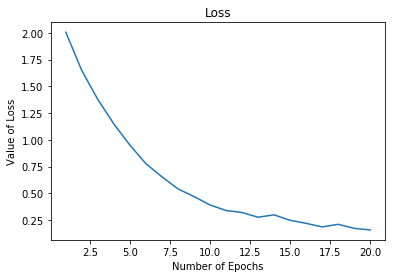

In [8]:
import matplotlib.pyplot as plt 

plt.title("Loss")
plt.ylabel("Value of Loss")
plt.xlabel("Number of Epochs")
plt.plot(x_axis, loss_values)

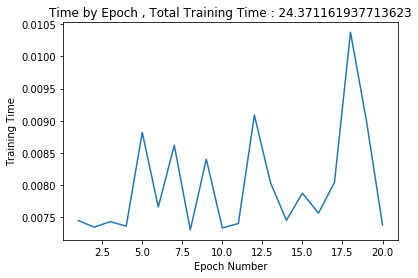

In [9]:
plt.title("Time by Epoch , Total Training Time : {}".format(end_of_training))
plt.ylabel("Training Time")
plt.xlabel("Epoch Number")
print(plt.plot(x_axis,epoch_times))

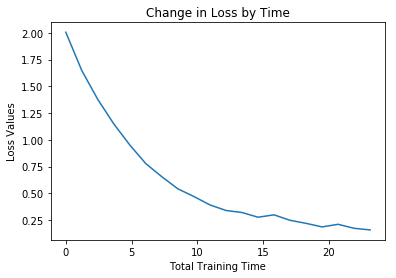

In [10]:
plt.title("Change in Loss by Time")
plt.ylabel("Loss Values")
plt.xlabel("Total Training Time")
plt.plot(x_interval_axis, loss_values)

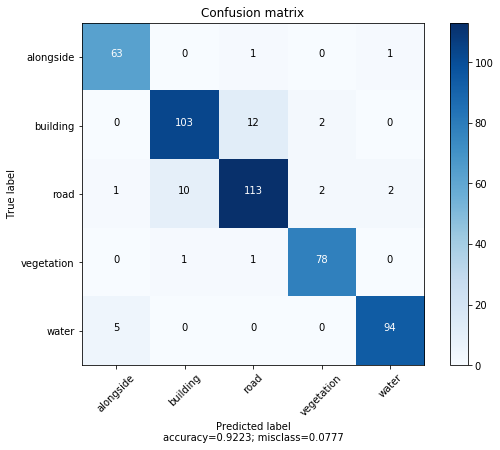

The Accuracy : 92.22903885480572
The Precision : 92.53215413723656
The Recall : 93.13760198135199
The F1 Score : 92.809890909477


In [11]:
from sklearn import metrics
from cm_helper import plot_confusion_matrix
cm = metrics.confusion_matrix(arr_label, arr_pred)
plot_confusion_matrix(cm, target_names= ["alongside", "building", "road" ,"vegetation", "water"], title='Confusion matrix' , normalize= False)

print(f"The Accuracy : { 100 * metrics.accuracy_score(arr_label, arr_pred)}")
print(f"The Precision : {100 * metrics.precision_score(arr_label, arr_pred, average= 'macro')}")
print(f"The Recall : {100 * metrics.recall_score(arr_label, arr_pred, average= 'macro')}")
print(f"The F1 Score : {100 *metrics.f1_score(arr_label, arr_pred, average = 'macro')}")